In [89]:
import pandas as pd
from scipy import stats
import numpy as np
import requests
from config import rapid_api_key, gkey
import gmaps
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format

In [2]:
historical_stock_prices = pd.read_csv('daily-historical-stock-prices-1970-2018/historical_stock_prices.csv')

In [3]:
historical_stocks = pd.read_csv('daily-historical-stock-prices-1970-2018/historical_stocks.csv')

In [4]:
historical_stock_prices.head()

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14


In [244]:
combined_stocks_df = pd.merge(historical_stock_prices, historical_stocks, on='ticker', how='inner')
currently_trading_ticker = combined_stocks_df.loc[combined_stocks_df['date'] == '2018-08-24']['ticker'].values
currently_trading_df = combined_stocks_df[combined_stocks_df['ticker'].isin(currently_trading_ticker)]
cleaned_currently_trading_df = currently_trading_df.dropna(axis=0)
sorted_current_trading = cleaned_currently_trading_df.sort_values(['date','ticker'])
sorted_current_trading = sorted_current_trading.reset_index()
sorted_current_trading.head()

,index,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,14218004,AA,7.1409,7.1409,1.9863,7.1409,7.2250,22500,1970-01-02,NYSE,ALCOA CORPORATION,BASIC INDUSTRIES,ALUMINUM
1,9736426,AEP,30.1250,30.6250,0.9834,30.1250,31.0000,10300,1970-01-02,NYSE,"AMERICAN ELECTRIC POWER COMPANY, INC.",PUBLIC UTILITIES,ELECTRIC UTILITIES: CENTRAL
2,15855608,ARNC,6.6998,6.6998,1.8457,6.6998,6.7701,24100,1970-01-02,NYSE,ARCONIC INC.,CAPITAL GOODS,METAL FABRICATIONS
3,15427303,BA,0.9259,0.9794,0.2293,0.9259,0.9794,634400,1970-01-02,NYSE,BOEING COMPANY (THE),CAPITAL GOODS,AEROSPACE
4,12465494,CAT,3.5417,3.4583,0.3785,3.4479,3.5417,276000,1970-01-02,NYSE,"CATERPILLAR, INC.",CAPITAL GOODS,CONSTRUCTION/AG EQUIPMENT/TRUCKS


In [13]:
#Drop rows prior to year 2000
df_cleaned_2000 = sorted_current_trading.drop(sorted_current_trading.index[:4649822])
df_cleaned_2000 = df_cleaned_2000.reset_index()
del df_cleaned_2000['index']
df_cleaned_2000.head()

,level_0,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,4649822,A,56.330471,51.502148,44.991753,48.193848,56.464592,4674300,2000-01-03,NYSE,"AGILENT TECHNOLOGIES, INC.",CAPITAL GOODS,BIOTECHNOLOGY: LABORATORY ANALYTICAL INSTRUMENTS
1,4649823,AA,99.724503,96.840897,71.915710,96.408363,100.157043,1291300,2000-01-03,NYSE,ALCOA CORPORATION,BASIC INDUSTRIES,ALUMINUM
2,4649824,AABA,110.730453,118.750000,118.750000,107.375000,119.250000,38469600,2000-01-03,NASDAQ,ALTABA INC.,TECHNOLOGY,EDP SERVICES
3,4649825,AAME,2.375000,2.312500,2.154104,2.250000,2.437500,5100,2000-01-03,NASDAQ,ATLANTIC AMERICAN CORPORATION,FINANCE,LIFE INSURANCE
4,4649826,AAN,5.370370,5.222222,4.541568,5.222222,5.370370,20800,2000-01-03,NYSE,"AARON&#39;S, INC.",TECHNOLOGY,DIVERSIFIED COMMERCIAL SERVICES


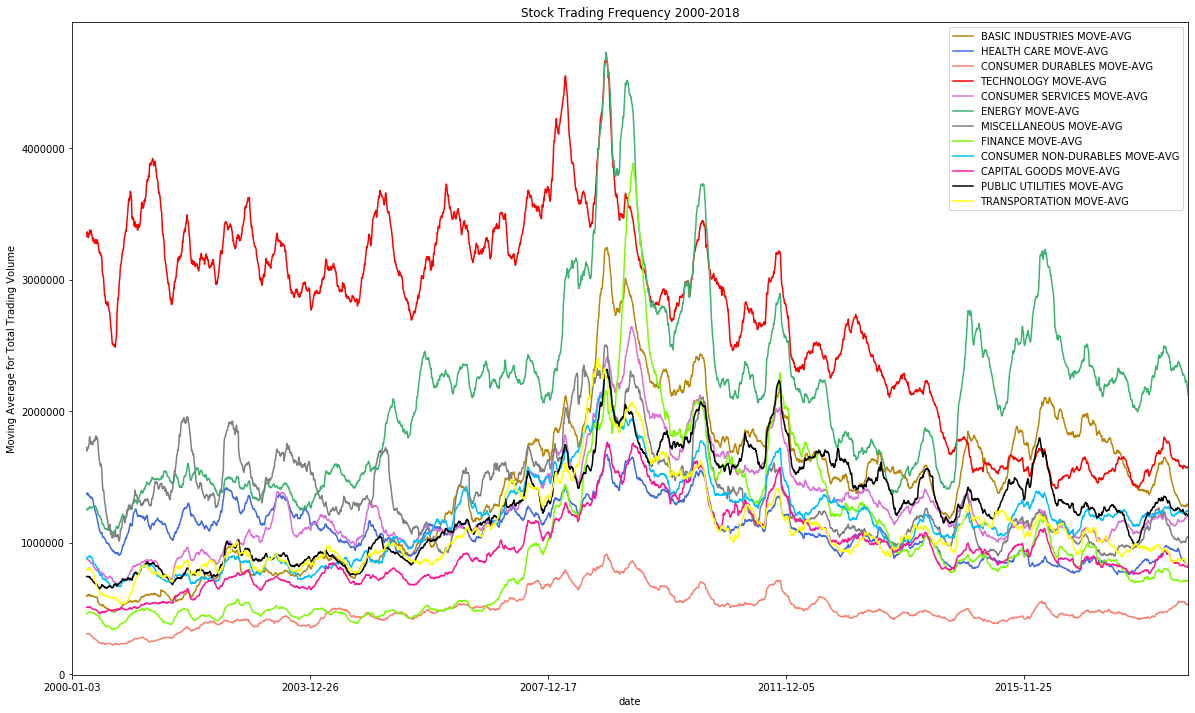

In [258]:
# Group by Sector, Date, calculate volume mean
sector_group = df_cleaned_2000.groupby(['sector','date'])
volume_mean = sector_group['volume'].mean()
sector_volume_mean = pd.DataFrame(volume_mean)
sector_volume_mean = sector_volume_mean.reset_index()
pd.options.display.float_format = "{:.2f}".format

# Pivot dataframe to view moving average of volume over 2 months
sector_volume_mean_pivot=sector_volume_mean.pivot(index='date',columns='sector')["volume"]
sector_volume_mean_pivot['BASIC INDUSTRIES MOVE-AVG'] = sector_volume_mean_pivot['BASIC INDUSTRIES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['HEALTH CARE MOVE-AVG'] = sector_volume_mean_pivot['HEALTH CARE'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['CONSUMER DURABLES MOVE-AVG'] = sector_volume_mean_pivot['CONSUMER DURABLES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['TECHNOLOGY MOVE-AVG'] = sector_volume_mean_pivot['TECHNOLOGY'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['CONSUMER SERVICES MOVE-AVG'] = sector_volume_mean_pivot['CONSUMER SERVICES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['ENERGY MOVE-AVG'] = sector_volume_mean_pivot['ENERGY'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['MISCELLANEOUS MOVE-AVG'] = sector_volume_mean_pivot['MISCELLANEOUS'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['FINANCE MOVE-AVG'] = sector_volume_mean_pivot['FINANCE'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['CONSUMER NON-DURABLES MOVE-AVG'] = sector_volume_mean_pivot['CONSUMER NON-DURABLES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['CAPITAL GOODS MOVE-AVG'] = sector_volume_mean_pivot['CAPITAL GOODS'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['PUBLIC UTILITIES MOVE-AVG'] = sector_volume_mean_pivot['PUBLIC UTILITIES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['TRANSPORTATION MOVE-AVG'] = sector_volume_mean_pivot['TRANSPORTATION'].rolling(window=63,center=False).mean()
sector_volume_moving_mean_pivot=sector_volume_mean_pivot.iloc[:, 12:]

# Chart the moving averages for volume per sector
avg_basic_industries_chart=sector_volume_moving_mean_pivot['BASIC INDUSTRIES MOVE-AVG'].plot(kind="line",figsize=(20,12),title="Stock Trading Frequency 2000-2018",color="darkgoldenrod")
avg_health_care_chart=sector_volume_moving_mean_pivot['HEALTH CARE MOVE-AVG'].plot(kind="line",color='royalblue').set_ylabel("Moving Average for Total Trading Volume",color="black")
avg_consumer_durables_chart=sector_volume_moving_mean_pivot['CONSUMER DURABLES MOVE-AVG'].plot(kind="line",color="salmon")
avg_technology_chart=sector_volume_moving_mean_pivot['TECHNOLOGY MOVE-AVG'].plot(kind="line",color="red")
avg_consumer_services_chart=sector_volume_moving_mean_pivot['CONSUMER SERVICES MOVE-AVG'].plot(kind="line",color="orchid")
avg_energy_chart=sector_volume_moving_mean_pivot['ENERGY MOVE-AVG'].plot(kind="line",color="mediumseagreen")
avg_miscellaneous_chart=sector_volume_moving_mean_pivot['MISCELLANEOUS MOVE-AVG'].plot(kind="line",color="gray")
avg_finance_chart=sector_volume_moving_mean_pivot['FINANCE MOVE-AVG'].plot(kind="line",color="lawngreen")
avg_consumer_non_durables_chart=sector_volume_moving_mean_pivot['CONSUMER NON-DURABLES MOVE-AVG'].plot(kind="line",color="deepskyblue")
avg_capital_goods_chart=sector_volume_moving_mean_pivot['CAPITAL GOODS MOVE-AVG'].plot(kind="line",color="deeppink")
avg_public_utilities_chart=sector_volume_moving_mean_pivot['PUBLIC UTILITIES MOVE-AVG'].plot(kind="line",color="black")
avg_transportation_chart=sector_volume_moving_mean_pivot['TRANSPORTATION MOVE-AVG'].plot(kind="line",color="yellow")
avg_energy_chart.legend() 
plt.savefig("General Stock Trading Frequency 2000-2018")


#The trading frequency of consumer_durable is very stable, which the trading frequency of technology,finance,energy. Thus we want to 
#investigate the return for those specific industry.


#Next we are trying to figure out the 5 year, 10 year, 15 year return.

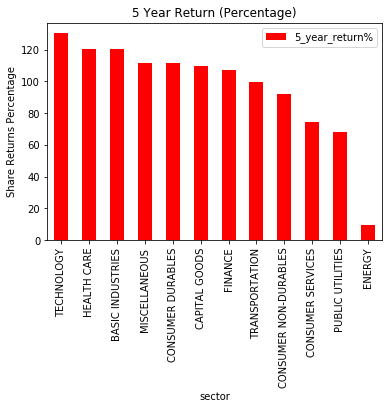

In [310]:
# 5 year return 
sector_ticker_price = df_cleaned_2000[['date', 'ticker', 'close', 'name', 'sector']]
sector_ticker_price = sector_ticker_price.set_index('ticker')
sector_ticker_price['2013_close'] = sector_ticker_price.loc[sector_ticker_price['date'] == '2013-01-04']['close']
sector_ticker_price['2018_close'] = sector_ticker_price.loc[sector_ticker_price['date'] == '2018-01-04']['close']
sector_ticker_price['5_year_return%'] = (sector_ticker_price.loc[sector_ticker_price['date'] == '2018-01-04']['close'] - sector_ticker_price.loc[sector_ticker_price['date'] == '2013-01-04']['close'])/sector_ticker_price.loc[sector_ticker_price['date'] == '2013-01-04']['close']*100
sector_ticker_price_five = sector_ticker_price[['name', 'sector', '5_year_return%']]
five_year_groupby_sector=sector_ticker_price_five.groupby("sector")
five_year_avg_change_by_sector=five_year_groupby_sector.mean()
five_year_avg_change_by_sector.round(2)
five_year_avg_change_by_sector = five_year_avg_change_by_sector.sort_values('5_year_return%',ascending=False)
five_year_plot=five_year_avg_change_by_sector.plot.bar(y="5_year_return%",color="r",title="5 Year Return (Percentage)")
plt.ylabel('Share Returns Percentage')
plt.savefig("Five_year_return%")

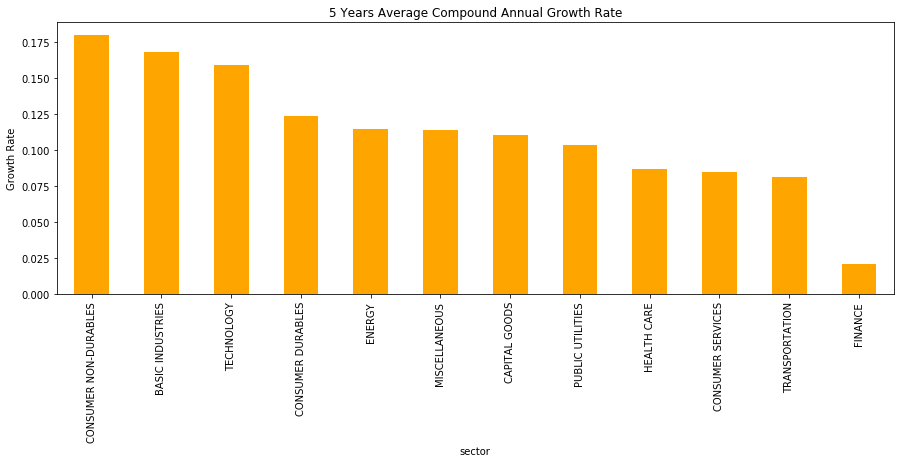

In [314]:
# 5 year Compound Annual Growth Rate
price_only=df_cleaned_2000.loc[:,['ticker','name','open','close','sector','date']]
price_only['change']=price_only['open']-price_only['close']
price_only['change percentage']=price_only['change']/price_only['open']
price_only=price_only[['ticker','open','close','change percentage','date','change','name','sector']]
price_only=price_only.set_index('ticker')

start_date = '2003-08-25'
end_dates = ['2004-08-24', '2008-08-25', '2013-08-26', '2018-08-24']
num_years = [1, 5, 10, 15]
all_stock_prices = price_only.loc[price_only['date']==start_date][['open','sector']].reset_index()
all_stock_prices.rename(columns = {'open':start_date}, inplace = True) 

for end_date in end_dates:
    all_stock_prices[end_date] = price_only.loc[price_only['date']==end_date]['close'].reset_index(drop=True) #price_only.loc[price_only['date']==end_date]['close'].reset_index(drop=True)

# Compute the CAGR metric
for end_date,num_year in zip(end_dates, num_years):
    all_stock_prices['CAGR_{}year'.format(num_year)] = all_stock_prices.apply(lambda row: (row[end_date] / row[start_date]) ** (float(1)/num_year) - 1.0, axis=1)
mean = all_stock_prices.groupby(['sector']).mean()
CAGR_mean= mean[['CAGR_1year','CAGR_5year','CAGR_10year','CAGR_15year']]
CAGR_mean=CAGR_mean.sort_values('CAGR_5year',ascending=False)
Avg_CAGR_chart=CAGR_mean['CAGR_5year'].plot(kind="bar",figsize=[15,5],color='orange',title="5 Years Average Compound Annual Growth Rate")
plt.ylabel('Growth Rate')
plt.savefig('Five_year_CAGR')

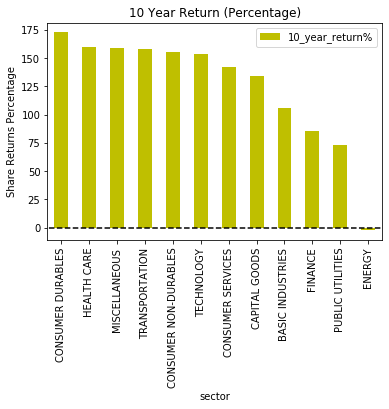

In [268]:
# 10 year return 
sector_ticker_price = df_cleaned_2000[['date', 'ticker', 'close', 'name', 'sector']]
sector_ticker_price = sector_ticker_price.set_index('ticker')
sector_ticker_price['2008_close'] = sector_ticker_price.loc[sector_ticker_price['date'] == '2008-01-03']['close']
sector_ticker_price['2018_close'] = sector_ticker_price.loc[sector_ticker_price['date'] == '2018-01-04']['close']
sector_ticker_price['10_year_return%'] = (sector_ticker_price.loc[sector_ticker_price['date'] == '2018-01-04']['close'] - sector_ticker_price.loc[sector_ticker_price['date'] == '2008-01-03']['close'])/sector_ticker_price.loc[sector_ticker_price['date'] == '2008-01-03']['close']*100
sector_ticker_price_ten = sector_ticker_price[['name', 'sector', '10_year_return%']]
sector_ticker_price_ten.round(2).head(10)
ten_year_groupby_sector=sector_ticker_price_ten.groupby("sector")
ten_year_avg_change_by_sector=ten_year_groupby_sector.mean()
ten_year_avg_change_by_sector = ten_year_avg_change_by_sector.sort_values('10_year_return%',ascending=False)
ten_year_avg_change_by_sector.round(2)
ten_year_avg_change_by_sector.plot.bar(color="y",title="10 Year Return (Percentage)")
plt.ylabel('Share Returns Percentage')
plt.hlines(0, -1, 12, linestyles='dashed');
plt.savefig("Ten_year_return%")

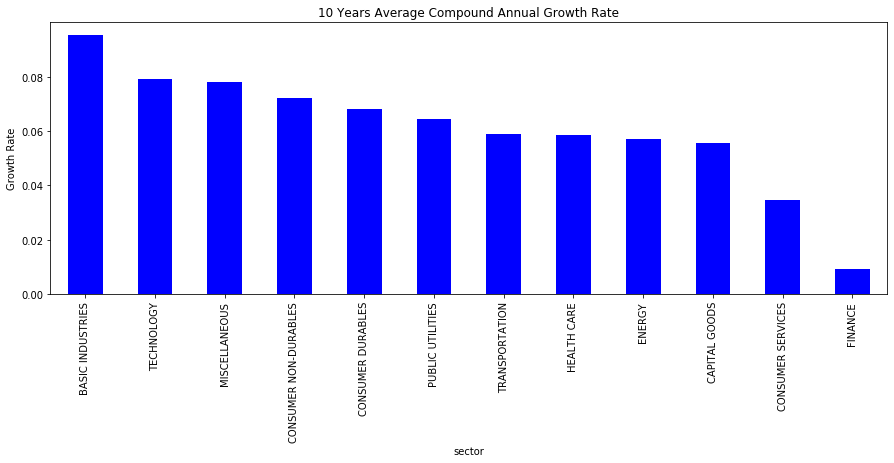

In [316]:
# 10 year CAGR
CAGR_10_mean=CAGR_mean.sort_values('CAGR_10year',ascending=False)
Avg_10yr_CAGR_chart=CAGR_10_mean['CAGR_10year'].plot(kind="bar",figsize=[15,5],color='blue',title="10 Years Average Compound Annual Growth Rate")
plt.ylabel('Growth Rate');
plt.savefig('Ten_year_CAGR')


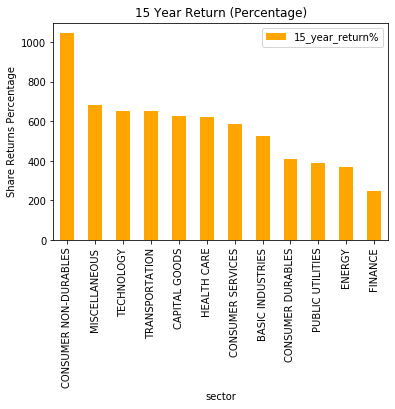

In [273]:
# 15 Year Return
sector_ticker_price = df_cleaned_2000[['date', 'ticker', 'close', 'name', 'sector']]
sector_ticker_price = sector_ticker_price.set_index('ticker')
sector_ticker_price['2003_close'] = sector_ticker_price.loc[sector_ticker_price['date'] == '2003-01-03']['close']
sector_ticker_price['2018_close'] = sector_ticker_price.loc[sector_ticker_price['date'] == '2018-01-04']['close']
sector_ticker_price['15_year_return%'] = (sector_ticker_price.loc[sector_ticker_price['date'] == '2018-01-04']['close'] - sector_ticker_price.loc[sector_ticker_price['date'] == '2003-01-03']['close'])/sector_ticker_price.loc[sector_ticker_price['date'] == '2003-01-03']['close']*100
sector_ticker_price_fifteen = sector_ticker_price[['name', 'sector', '15_year_return%']]
sector_ticker_price_fifteen.head(10)
fifteen_year_groupby_sector=sector_ticker_price_fifteen.groupby("sector")
fifteen_year_avg_change_by_sector=fifteen_year_groupby_sector.mean()
fifteen_year_avg_change_by_sector=fifteen_year_avg_change_by_sector.sort_values('15_year_return%', ascending=False)
fifteen_year_avg_change_by_sector.round(2)
fifteen_year_avg_change_by_sector.plot.bar(color="orange",title="15 Year Return (Percentage)")
plt.ylabel('Share Returns Percentage');
plt.savefig("Fifteen_year_return%")

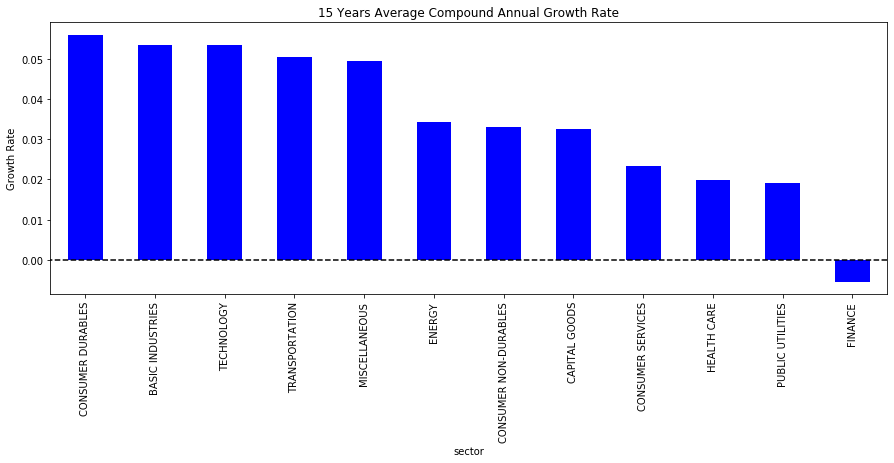

In [320]:
# 15 year CAGR
CAGR_15_mean=CAGR_mean.sort_values('CAGR_15year',ascending=False)
Avg_10yr_CAGR_chart=CAGR_15_mean['CAGR_15year'].plot(kind="bar",figsize=[15,5],color='blue',title="15 Years Average Compound Annual Growth Rate")
plt.ylabel('Growth Rate');
plt.hlines(0,-1,12,linestyles='dashed')
plt.savefig('Fifteen_year_CAGR')

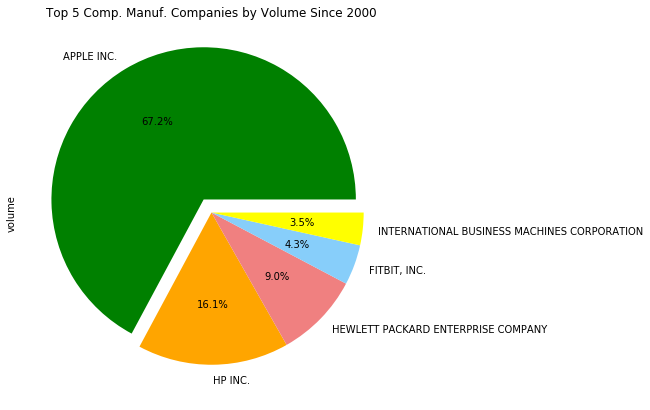

In [291]:
#Look into Tech Sector and identify the industry with highest trading volume
tech_sector_df=df_cleaned_2000.loc[(df_cleaned_2000['sector'] == 'TECHNOLOGY')]
groupby_industry=tech_sector_df.groupby("industry")
groupby_industry=groupby_industry["volume"].mean()
groupby_industry_df=pd.DataFrame(groupby_industry)
groupby_industry_sort=groupby_industry_df.sort_values(by=["volume"],ascending=False)
groupby_industry_sort.reset_index()

#Creating a new data frame tha shows 10 year price change for all the companies in Technology sector
tech_extracted= tech_sector_df[['date', 'ticker', 'close', 'name',"industry"]]
tech_extracted = tech_extracted.set_index('ticker')
tech_extracted['2008_close'] = tech_extracted.loc[tech_extracted['date'] == '2008-01-03']['close']
tech_extracted['2018_close'] = tech_extracted.loc[tech_extracted['date'] == '2018-01-04']['close']
tech_extracted['10_year_change%'] = (tech_extracted.loc[tech_extracted['date'] == '2018-01-04']['close'] - tech_extracted.loc[tech_extracted['date'] == '2008-01-03']['close'])/tech_extracted.loc[tech_extracted['date'] == '2003-01-03']['close']*100
tech_extracted_ten = tech_extracted[['name', 'industry','10_year_change%']]
tech_extracted_ten.head()

#Find out which industry within technology sector has most 10 year return from 2008 to 2018.
tech_sector_ten=tech_extracted.groupby("industry")
tech_sector_ten=tech_sector_ten.mean()
tech_sector_ten.sort_values(by=["10_year_change%"],ascending=False).reset_index()

#To find out which company in "Computer Manufacturing" industry has highest trading volume.
comp_manuf=tech_sector_df.loc[(tech_sector_df['industry'] == 'COMPUTER MANUFACTURING')]
company_name=comp_manuf.groupby(["name"])
company_name=company_name["volume"].mean()
company_name_df=pd.DataFrame(company_name)
company_name_df=company_name_df.sort_values(by=["volume"],ascending=False)

#Extracting the top five companies that have highest trading volumes. 
top_five=company_name_df.iloc[0:5,:]
sizes = [220, 95, 80, 100]
colors = ["green", "orange", "lightcoral", "lightskyblue", 'yellow']
explode = (0.1, 0, 0, 0, 0)
top_five_pie=top_five.plot.pie(y="volume",figsize=(15,7),
                                explode=explode, colors=colors, autopct="%1.1f%%", 
                               title="Top 5 Comp. Manuf. Companies by Volume Since 2000")
plt.legend().set_visible(False)
plt.savefig("Top five computer manufacturing companies")


In [292]:
# Now that we have an understanding of the most profitable sectors
# and industries over the past 5, 10, and 15 years, let's take a
# look at where the best performing companies are located, how this
# has changed from 2000 to 2018. The optimal companies to target for 
# consistent daily returns, and how the media can lend guidance on 
# stock purchas or sells. 

In [293]:
# Small Identify outliers based on average volume for year 2000
Q1_vol = df_cleaned_2000['volume'].quantile(0.25)
Q3_vol = df_cleaned_2000['volume'].quantile(0.75)
vol_IQR = Q3_vol - Q1_vol

#Filter rows where volume is considered a low outlier
df_2000_no_out = df_cleaned_2000.loc[df_cleaned_2000['volume'] > Q1_vol]
df_2000_no_out = df_2000_no_out.reset_index(drop=True)
del df_2000_no_out['level_0']

# Stock data beginning year 2000
df_cleaned_2000_boy = df_2000_no_out.loc[df_2000_no_out['date']=='2000-01-03']
df_cleaned_2000_boy = df_cleaned_2000_boy.reset_index()
del df_cleaned_2000_boy['index']

# Stock data end year 2000
df_cleaned_2000_eoy = df_2000_no_out.loc[df_2000_no_out['date']=='2000-12-29']
df_cleaned_2000_eoy = df_cleaned_2000_eoy.reset_index()
del df_cleaned_2000_eoy['index']

# Combine beginning of year and end of year data
full_year_2000 = pd.merge(df_cleaned_2000_boy, df_cleaned_2000_eoy, on=['ticker'], how='inner')
full_year_2000 = full_year_2000[['ticker', 'name_x', 'exchange_x', 'sector_x', 'industry_x', 'date_x', 'open_x', 'close_x', 'adj_close_x', 'volume_x', 'date_y',  'open_y', 'close_y', 'adj_close_y', 'volume_y']]
full_year_2000['yearly_value_change'] = full_year_2000['adj_close_y'] - full_year_2000['open_x']
full_year_2000 = full_year_2000[['ticker', 'name_x', 'yearly_value_change']]

# Best stocks in terms of per-share value from beginning of year to end of year
desc_2000_yearly_change = full_year_2000.sort_values(['yearly_value_change'],ascending=False)
pos_year_change_2000 = desc_2000_yearly_change[:100]
pos_year_change_2000 = pos_year_change_2000.reset_index(drop=False)
del pos_year_change_2000['index']

# Call the Yahoo! Finance API to obtain address for top 100 growth stocks
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-summary"

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapid_api_key
    }

coordinates = []

for ticker in pos_year_change_2000['ticker'].values:    
    try:
        querystring = {"region":"US","symbol":ticker}
        tick_response = requests.get(url, headers=headers, params=querystring).json()
        tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city']
    except:
        continue        
    try:
        address = tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city'], tick_response['summaryProfile']['state']
        address = ','.join(address)
    except KeyError as e:
        if e.args[0] == 'state':
            address = tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city'], tick_response['summaryProfile']['country']
            address = ','.join(address)
    
    # Call the Google GeoCode API to obtain coordinates for stock address
    target_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={gkey}'
    geo_response = requests.get(target_url).json()
    city_lat = geo_response['results'][0]['geometry']['location']['lat']
    city_lng = geo_response['results'][0]['geometry']['location']['lng']
    city_tup = (city_lat, city_lng)
    coordinates.append(city_tup)
    
# Plot those coordinates on Google Maps with Heatmap overlay
figure_layout = {
    'width': '1500px',
    'height': '900px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'}
gmaps.configure(api_key=gkey)
fig_2000 = gmaps.figure()
heat_layer = gmaps.heatmap_layer(coordinates, dissipating=False, max_intensity=3, point_radius=2)
fig_2000.add_layer(heat_layer)
fig_2000

Figure(layout=FigureLayout(height='420px'))

In [ ]:
# Take a similar approach and visualize locations of the best growth
# stocks for 2018. Do we have a bias of the bay area being where all
# the money is at? 

In [294]:
#Dataframe for stocks from Aug 2017 - Aug 2018
df_cleaned_2018 = sorted_current_trading.loc[sorted_current_trading['date'] >= '2017-08-24']
df_cleaned_2018 = df_cleaned_2018.reset_index()
del df_cleaned_2018['index']
del df_cleaned_2018['level_0']
Q1_2018_vol = df_cleaned_2018['volume'].quantile(0.25)
df_2018_no_out = df_cleaned_2018.loc[df_cleaned_2018['volume'] > Q1_2018_vol]
df_2018_no_out = df_2018_no_out.reset_index(drop=True)

# Stock data beginning year Aug 2017
df_cleaned_2018_boy = df_2018_no_out.loc[df_2018_no_out['date']=='2017-08-24']
df_cleaned_2018_boy = df_cleaned_2018_boy.reset_index(drop=True)

# Stock data end year Aug 2018
df_cleaned_2018_eoy = df_2018_no_out.loc[df_2018_no_out['date']=='2018-08-24']
df_cleaned_2018_eoy = df_cleaned_2018_eoy.reset_index(drop=True)

# Beginning of 2017 year and end of 2018 year data
full_year_2018 = pd.merge(df_cleaned_2018_boy, df_cleaned_2018_eoy, on=['ticker'], how='inner')
full_year_2018 = full_year_2018[['ticker', 'name_x', 'exchange_x', 'sector_x', 'industry_x', 'date_x', 'open_x', 'close_x', 'adj_close_x', 'volume_x', 'date_y',  'open_y', 'close_y', 'adj_close_y', 'volume_y']]
full_year_2018['yearly_value_change'] = full_year_2018['adj_close_y'] - full_year_2018['open_x']
full_year_2018 = full_year_2018[['ticker', 'name_x', 'yearly_value_change']]

# Worst stocks in terms of per-share value from beginning of year to end of year
asc_2018_yearly_change = full_year_2018.sort_values(['yearly_value_change'])
neg_year_change_2018 = asc_2018_yearly_change[:100]
neg_year_change_2018 = neg_year_change_2018.reset_index(drop=False)
del neg_year_change_2018['index']

# Best stocks in terms of per-share value from beginning of year to end of year
desc_2018_yearly_change = full_year_2018.sort_values(['yearly_value_change'],ascending=False)
pos_year_change_2018 = desc_2018_yearly_change[:100]
pos_year_change_2018 = pos_year_change_2018.reset_index(drop=False)
del pos_year_change_2018['index']

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-summary"

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapid_api_key
    }

coordinates = []

for ticker in pos_year_change_2018['ticker'].values:    
    try:
        querystring = {"region":"US","symbol":ticker}
        tick_response = requests.get(url, headers=headers, params=querystring).json()
        tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city']
    except:
        continue        
    try:
        address = tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city'], tick_response['summaryProfile']['state']
        address = ','.join(address)
    except KeyError as e:
        if e.args[0] == 'state':
            address = tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city'], tick_response['summaryProfile']['country']
            address = ','.join(address)
    
    # Obtain coordinates for ticker address
    target_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={gkey}'
    geo_response = requests.get(target_url).json()
    city_lat = geo_response['results'][0]['geometry']['location']['lat']
    city_lng = geo_response['results'][0]['geometry']['location']['lng']
    city_tup = (city_lat, city_lng)
    coordinates.append(city_tup)
    
figure_layout = {
    'width': '1500px',
    'height': '900px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'}
gmaps.configure(api_key=gkey)
fig_2018 = gmaps.figure()
heat_layer = gmaps.heatmap_layer(coordinates, dissipating=False, max_intensity=3, point_radius=2)

fig_2018.add_layer(heat_layer)
fig_2018

Figure(layout=FigureLayout(height='420px'))

Text(0, 0.5, 'Average Transaction Volume (Tens of Millions)')

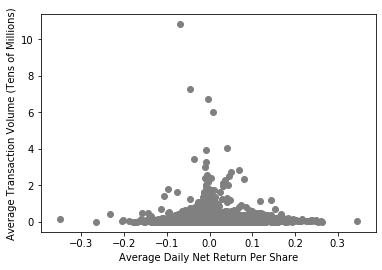

In [296]:
# Scatter plot of the Avg Volume per Day & Avg Share Return per Day
ticker_group = df_cleaned_2018.groupby('ticker')
avg_volume = ticker_group['volume'].mean()
avg_vol_df = pd.DataFrame(avg_volume).sort_values('volume', ascending=False)
avg_vol_df = avg_vol_df.reset_index()
avg_vol_df = avg_vol_df.rename(columns={'volume':'average_volume_2018'})

df_cleaned_2018['daily_net_return'] = df_cleaned_2018['close'] - df_cleaned_2018['open']
df_cleaned_2018 = df_cleaned_2018.loc[(df_cleaned_2018['daily_net_return'] < 2) & (df_cleaned_2018['daily_net_return'] > -2)]
daily_return_group = df_cleaned_2018.groupby('ticker')
daily_net_ret = daily_return_group['daily_net_return'].mean()
daily_net_ret_df = pd.DataFrame(daily_net_ret).sort_values('daily_net_return', ascending=False)
daily_net_ret_df = daily_net_ret_df.reset_index()

vol_return_2018 = pd.merge(avg_vol_df, daily_net_ret_df, on='ticker', how='inner')

plt.scatter(vol_return_2018['daily_net_return'], vol_return_2018['average_volume_2018'] / 10000000)
plt.xlabel('Average Daily Net Return Per Share')
plt.ylabel('Average Transaction Volume (Tens of Millions)')

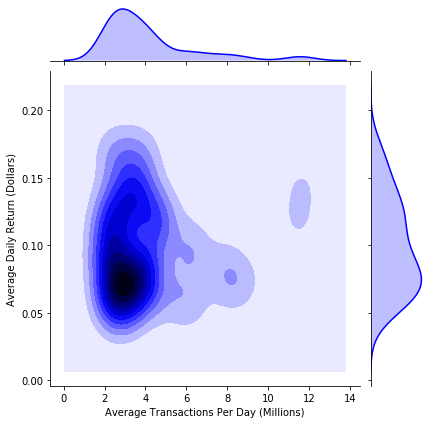

In [300]:
# After removing outliers, is there a distribution between daily
# returns per share and stock transactions per day? 

top_500_net_ret = pd.DataFrame(daily_net_ret).sort_values('daily_net_return', ascending=False)[:500]
Q1_net_ret = top_500_net_ret['daily_net_return'].quantile(0.25)
Q3_net_ret = top_500_net_ret['daily_net_return'].quantile(0.75)
IQR_net_ret = Q3_net_ret - Q1_net_ret
clean_net_ret = top_500_net_ret.loc[(top_500_net_ret['daily_net_return'] > (Q1_net_ret - 1.5 * IQR_net_ret)) & (top_500_net_ret['daily_net_return'] < (Q3_net_ret + 1.5 * IQR_net_ret))]

top_500_avg_vol = pd.DataFrame(avg_volume).sort_values('volume', ascending=False)[:500]
Q1_avg_vol = top_500_avg_vol['volume'].quantile(0.25)
Q3_avg_vol = top_500_avg_vol['volume'].quantile(0.75)
IQR_avg_vol = Q3_avg_vol - Q1_avg_vol
clean_avg_vol = top_500_avg_vol.loc[(top_500_avg_vol['volume'] > (Q1_avg_vol - 1.5 * IQR_avg_vol)) & (top_500_avg_vol['volume'] < (Q3_avg_vol + 1.5 * IQR_avg_vol))]

clean_vol_return_2018 = pd.merge(clean_avg_vol, clean_net_ret, on='ticker', how='inner')
clean_vol_return_2018['volume'] = clean_vol_return_2018['volume'] / 1000000
clean_vol_return_2018 = clean_vol_return_2018.rename(columns={'volume': 'Average Transactions Per Day (Millions)',
                                     'daily_net_return': 'Average Daily Return (Dollars)'})

sns.jointplot(x=clean_vol_return_2018['Average Transactions Per Day (Millions)'], y=clean_vol_return_2018['Average Daily Return (Dollars)'], kind="kde", color='blue');
plt.savefig('2018 Volume Per Day vs Per-Share Daily Returns')

Please enter a US stock ticker: Amzn


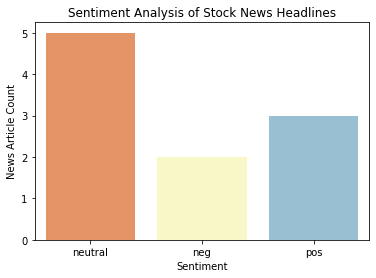

In [303]:
# Take a user-supplied stock-ticker, query sentiment analysis API
# with news headlines about the stock. Visualize the sentiment in
# a bar chart. 

news_url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-news"
user_stock = input('Please enter a US stock ticker: ')
news_querystring = {"region":"US","category":user_stock}
news_headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapid_api_key
    }
response = requests.get(news_url, headers=news_headers, params=news_querystring).json()

text_url = 'http://text-processing.com/api/sentiment/'

news_response = response['items']['result']

stock_classifications = []

for news in news_response:
    title = news['title']
    sentiment_data = {'text':title}
    sentiment_response = requests.post(url=text_url, data=sentiment_data).json()
    stock_classifications.append(sentiment_response['label'])
    
sns.countplot(x=stock_classifications, palette='RdYlBu')
plt.title('Sentiment Analysis of Stock News Headlines')
plt.xlabel('Sentiment')
plt.ylabel('News Article Count');
plt.savefig('Sentiment Bar Chart for Given Stock')